In [1]:
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA, SparsePCA
from sklearn.cross_validation import KFold, train_test_split
from sklearn.linear_model import Lasso, Ridge, SGDRegressor
from sklearn.decomposition import TruncatedSVD
from scipy.stats import spearmanr
import sklearn.svm as svm
import scipy.sparse
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline

In [2]:
essay_df = pd.read_csv("datasets/training_set_rel3.tsv", delimiter="\t")
print essay_df.shape
essay_df.head(2)

(12976, 28)


,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,...,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
0,1,1,"Dear local newspaper, I think effects computer...",4,4,NaN,8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,NaN,9,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
prompts_df = pd.read_csv("prompts.csv")
prompts_df.rename(columns={"prompt":"essay_set", "text":"prompt_text"}, inplace=True)
prompts_df

,essay_set,prompt_text
0,1,"More and more people use computers, but not ev..."
1,2,All of us can think of a book that we hope non...
2,3,Write a response that explains how the feature...
3,4,"When they come back, Saeng vowed silently to h..."
4,5,Describe the mood created by the author in the...
5,6,"Based on the excerpt, describe the obstacles t..."
6,7,Write about patience. Being patient means that...
7,8,"""If you want a place in the sun, you will have..."


In [4]:
essay_df = essay_df.join(prompts_df.set_index("essay_set"), on="essay_set", how="inner")

In [5]:
vectorizer = TfidfVectorizer(stop_words="english", min_df=4, decode_error="ignore", ngram_range=(1, 1))
corpus = essay_df["essay"].values + essay_df["prompt_text"].values
sparse_essay_vector = vectorizer.fit_transform(corpus)

sparse_essay_vector.shape, type(sparse_essay_vector)

essay_df["essay_length"] = map(len, essay_df["essay"])
sparse_essay_length = scipy.sparse.csc_matrix(essay_df["essay_length"]).transpose()
sparse_essay_set = scipy.sparse.csc_matrix(essay_df["essay_set"]).transpose()
y = essay_df["domain1_score"]

In [ ]:
cosine_matrix = cosine_similarity(sparse_essay_vector)

In [ ]:
pca = PCA(n_components=10)
pca.fit_transform(cosine_matrix)

In [6]:
def tune_lasso(X, y, alphas=[.0001, .001, .01 , 1]):
    lasso_alpha_list = alphas
    lasso_spearman_value = []

    for alpha in lasso_alpha_list: 
        lasso_spearman_temp = []

        print "Testing alpha = {0}".format(alpha)

        # gives us the different folds of our data to test against
        folds = KFold(X.shape[0], n_folds=2, shuffle=True)

        for train_indices, test_indices in folds:
            X_train, X_test = X[train_indices], X[test_indices]
            y_train, y_test = y[train_indices], y[test_indices]

            lasso = Lasso(alpha=alpha)

            # fit on the training data 
            lasso.fit(X_train, y_train)

            spearman_r = scipy.stats.spearmanr(lasso.predict(X_test), y_test)
            lasso_spearman_temp.append(spearman_r[0])

        lasso_spearman_value.append(np.mean(lasso_spearman_temp))
    
    return alphas, lasso_spearman_value

In [7]:
def plot_score(x, y, title, xlabel, ylabel, vlabel, pic_title):
    plt.figure(figsize=(8, 6))
    plt.title(title, fontsize=12)
    plt.semilogx(x, y)

    best_index = np.argmax(np.array(y))
    plt.axvline(x[best_index], c='r', label=vlabel.format(y[best_index]))

    plt.xlabel(xlabel, fontsize=13)
    plt.ylabel(ylabel, fontsize=13)
    plt.legend()
    plt.savefig("graphs/" + pic_title + ".png")
    plt.show()

In [9]:
X = scipy.sparse.hstack([sparse_essay_vector, sparse_essay_length, sparse_essay_set], format="csr")

alphas_1, spearman_values_1 = tune_lasso(X, y)
print "\nAlphas:", alphas_1
print "Spearman:", spearman_values_1

Testing alpha = 0.0001


/Library/Python/2.7/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


Testing alpha = 0.001
Testing alpha = 0.01
Testing alpha = 1

Alphas: [0.0001, 0.001, 0.01, 1]
Spearman: [0.8739209930909726, 0.88133433101058178, 0.84888749795521057, 0.68266726033425496]


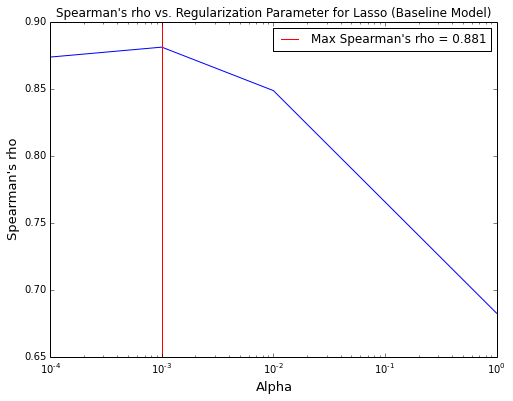

In [10]:
plot_score(alphas_1, spearman_values_1, "Spearman's rho vs. Regularization Parameter for Lasso (Baseline Model)", "Alpha", "Spearman's rho", "Max Spearman's rho = {0:.3f}", "baseline")

In [11]:
# try lsa on the essay vector, and then concatenate the essay length and set
lsa = TruncatedSVD(n_components=100)
lsa = lsa.fit_transform(sparse_essay_vector)

X = scipy.sparse.hstack([lsa, sparse_essay_length, sparse_essay_set], format="csr")

alphas_2, spearman_values_2 = tune_lasso(X, y)
print "\nAlphas:", alphas_2
print "Spearman:", spearman_values_2

Testing alpha = 0.0001
Testing alpha = 0.001
Testing alpha = 0.01
Testing alpha = 1

Alphas: [0.0001, 0.001, 0.01, 1]
Spearman: [0.86196834434021175, 0.86204051312455598, 0.84808415291761596, 0.68263416936244792]


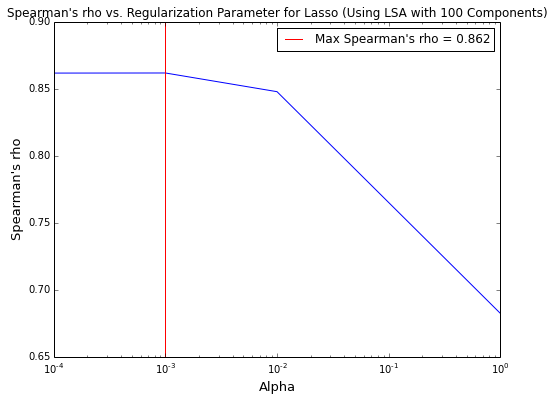

In [12]:
plot_score(alphas_2, spearman_values_2, "Spearman's rho vs. Regularization Parameter for Lasso (Using LSA with 100 Components)", "Alpha", "Spearman's rho", "Max Spearman's rho = {0:.3f}", "LSA(100)")

In [19]:
vectorizer = TfidfVectorizer(stop_words="english", min_df=4, decode_error="ignore", ngram_range=(1, 2))
corpus = essay_df["essay"].values + essay_df["prompt_text"].values
sparse_essay_vector_bigrams = vectorizer.fit_transform(corpus)

sparse_essay_vector_bigrams.shape, type(sparse_essay_vector_bigrams)

((12976, 53212), scipy.sparse.csr.csr_matrix)

In [20]:
# try lsa on the essay vector, and then concatenate the essay length and set
lsa = TruncatedSVD(n_components=100)
lsa = lsa.fit_transform(sparse_essay_vector_bigrams)

X = scipy.sparse.hstack([lsa, sparse_essay_length, sparse_essay_set], format="csr")

alphas_bigram, spearman_values_bigram = tune_lasso(X, y)
print "\nAlphas:", alphas_bigram
print "Spearman:", spearman_values_bigram

Testing alpha = 0.0001
Testing alpha = 0.001
Testing alpha = 0.01
Testing alpha = 1

Alphas: [0.0001, 0.001, 0.01, 1]
Spearman: [0.87878697692630636, 0.8791514732061434, 0.86412677060576448, 0.68292632404163056]


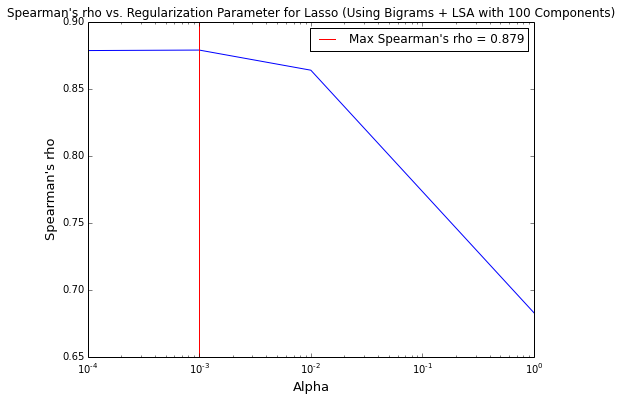

In [21]:
plot_score(alphas_bigram, spearman_values_bigram, "Spearman's rho vs. Regularization Parameter for Lasso (Using Bigrams + LSA with 100 Components)", "Alpha", "Spearman's rho", "Max Spearman's rho = {0:.3f}", "Bigrams + LSA(100)")

In [22]:
vectorizer = TfidfVectorizer(stop_words="english", min_df=4, decode_error="ignore", ngram_range=(1, 3))
corpus = essay_df["essay"].values + essay_df["prompt_text"].values
sparse_essay_vector_trigrams = vectorizer.fit_transform(corpus)

sparse_essay_vector_trigrams.shape, type(sparse_essay_vector_trigrams)

((12976, 65697), scipy.sparse.csr.csr_matrix)

In [30]:
# try lsa on the essay vector, and then concatenate the essay length and set
lsa = TruncatedSVD(n_components=100)
lsa = lsa.fit_transform(sparse_essay_vector_trigrams)

X = scipy.sparse.hstack([lsa, sparse_essay_length, sparse_essay_set], format="csr")

alphas_trigram, spearman_values_trigram = tune_lasso(X, y)
print "\nAlphas:", alphas_trigram
print "Spearman:", spearman_values_trigram

 Testing alpha = 0.0001
Testing alpha = 0.001
Testing alpha = 0.01
Testing alpha = 1

Alphas: [0.0001, 0.001, 0.01, 1]
Spearman: [0.8899759094666474, 0.89002694746309374, 0.87962144732105685, 0.6820486938397009]


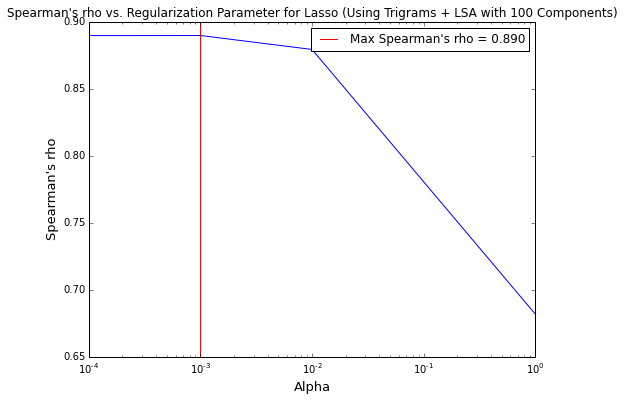

In [31]:
plot_score(alphas_trigram, spearman_values_trigram, "Spearman's rho vs. Regularization Parameter for Lasso (Using Trigrams + LSA with 100 Components)", "Alpha", "Spearman's rho", "Max Spearman's rho = {0:.3f}", "Trigrams + LSA(100)")

In [25]:
vectorizer = TfidfVectorizer(stop_words="english", min_df=4, decode_error="ignore", ngram_range=(1, 4))
corpus = essay_df["essay"].values + essay_df["prompt_text"].values
sparse_essay_vector_quadgrams = vectorizer.fit_transform(corpus)

sparse_essay_vector_quadgrams.shape, type(sparse_essay_vector_quadgrams)

# try lsa on the essay vector, and then concatenate the essay length and set
lsa = TruncatedSVD(n_components=100)
lsa = lsa.fit_transform(sparse_essay_vector_quadgrams)

X = scipy.sparse.hstack([lsa, sparse_essay_length, sparse_essay_set], format="csr")

alphas_quadgram, spearman_values_quadgram = tune_lasso(X, y)
print "\nAlphas:", alphas_quadgram
print "Spearman:", spearman_values_quadgram

((12976, 71263), scipy.sparse.csr.csr_matrix)

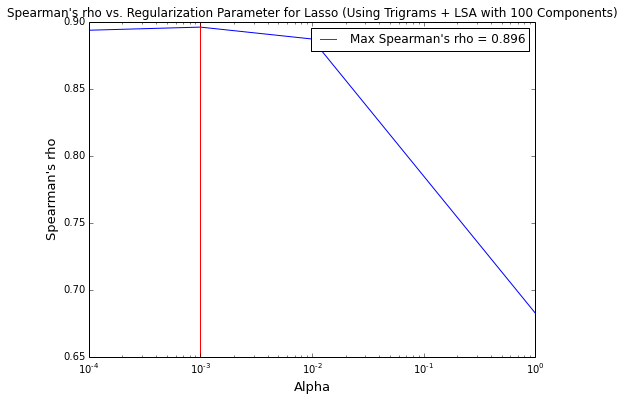

In [27]:
plot_score(alphas_quadgram, spearman_values_quadgram, "Spearman's rho vs. Regularization Parameter for Lasso (Using Trigrams + LSA with 100 Components)", "Alpha", "Spearman's rho", "Max Spearman's rho = {0:.3f}", "Quadgrams + LSA(100)")

Testing alpha = 0.0001
Testing alpha = 0.001
Testing alpha = 0.01
Testing alpha = 1

Alphas: [0.0001, 0.001, 0.01, 1]
Spearman: [0.90004177842346478, 0.90244055706651549, 0.89975227780057709, 0.68269899185004401]


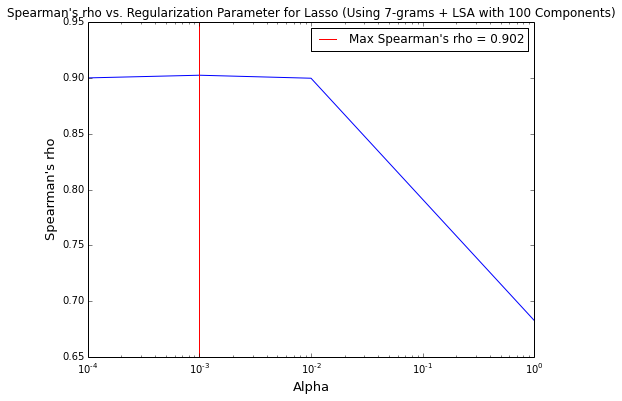

In [28]:
vectorizer = TfidfVectorizer(stop_words="english", min_df=4, decode_error="ignore", ngram_range=(1, 7))
corpus = essay_df["essay"].values + essay_df["prompt_text"].values
sparse_essay_vector_7grams = vectorizer.fit_transform(corpus)

sparse_essay_vector_7grams.shape, type(sparse_essay_vector_7grams)

# try lsa on the essay vector, and then concatenate the essay length and set
lsa = TruncatedSVD(n_components=100)
lsa = lsa.fit_transform(sparse_essay_vector_7grams)

X = scipy.sparse.hstack([lsa, sparse_essay_length, sparse_essay_set], format="csr")

alphas_7grams, spearman_values_7grams = tune_lasso(X, y)
print "\nAlphas:", alphas_7grams
print "Spearman:", spearman_values_7grams

plot_score(alphas_7grams, spearman_values_7grams, "Spearman's rho vs. Regularization Parameter for Lasso (Using 7-grams + LSA with 100 Components)", "Alpha", "Spearman's rho", "Max Spearman's rho = {0:.3f}", "7-grams + LSA(100)")

Testing alpha = 0.0001
Testing alpha = 0.001
Testing alpha = 0.01
Testing alpha = 1

Alphas: [0.0001, 0.001, 0.01, 1]
Spearman: [0.90130061194810152, 0.90545739568689099, 0.90632647231755059, 0.68268673863660434]


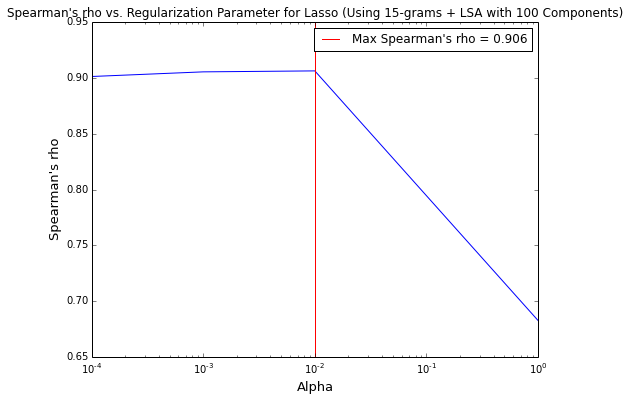

In [9]:
vectorizer = TfidfVectorizer(stop_words="english", min_df=4, decode_error="ignore", ngram_range=(1, 15))
corpus = essay_df["essay"].values + essay_df["prompt_text"].values
sparse_essay_vector_15grams = vectorizer.fit_transform(corpus)

sparse_essay_vector_15grams.shape, type(sparse_essay_vector_15grams)

# try lsa on the essay vector, and then concatenate the essay length and set
lsa = TruncatedSVD(n_components=100)
lsa = lsa.fit_transform(sparse_essay_vector_15grams)

X = scipy.sparse.hstack([lsa, sparse_essay_length, sparse_essay_set], format="csr")

alphas_15grams, spearman_values_15grams = tune_lasso(X, y)
print "\nAlphas:", alphas_15grams
print "Spearman:", spearman_values_15grams

plot_score(alphas_15grams, spearman_values_15grams, "Spearman's rho vs. Regularization Parameter for Lasso (Using 15-grams + LSA with 100 Components)", "Alpha", "Spearman's rho", "Max Spearman's rho = {0:.3f}", "15-grams + LSA(100)")

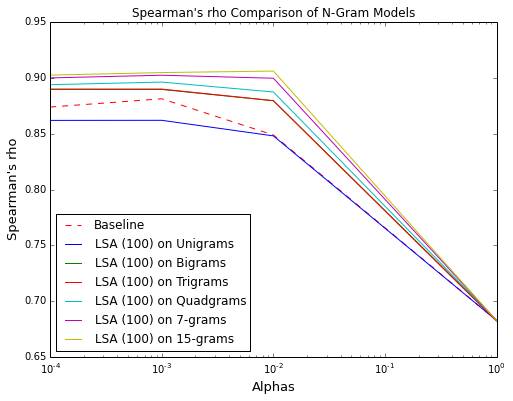

In [41]:
plt.figure(figsize=(8, 6))
plt.title("Spearman's rho Comparison of N-Gram Models", fontsize=12)

plt.semilogx(alphas_1, spearman_values_1, "r--", label="Baseline")
plt.semilogx(alphas_2, spearman_values_2, label="LSA (100) on Unigrams")
plt.semilogx(alphas_bigram, spearman_values_bigram, label="LSA (100) on Bigrams")
plt.semilogx(alphas_trigram, spearman_values_trigram, label="LSA (100) on Trigrams")
plt.semilogx(alphas_quadgram, spearman_values_quadgram, label="LSA (100) on Quadgrams")
plt.semilogx(alphas_7grams, spearman_values_7grams, label="LSA (100) on 7-grams")
plt.semilogx(alphas_15grams, spearman_values_15grams, label="LSA (100) on 15-grams")

# best_index = np.argmax(np.array(y))
# plt.axvline(x[best_index], c='r', label=vlabel.format(y[best_index]))

plt.xlabel("Alphas", fontsize=13)
plt.ylabel("Spearman's rho", fontsize=13)
plt.legend(loc="lower left")
plt.savefig("graphs/" + "ngram_comparison" + ".png")
plt.show()

In [13]:
# try lsa on the essay vector, and then concatenate the essay length and set
lsa = TruncatedSVD(n_components=100)
lsa = lsa.fit_transform(sparse_essay_vector)

X = scipy.sparse.hstack([lsa, sparse_essay_vector, sparse_essay_length, sparse_essay_set], format="csr")

alphas_3, spearman_values_3 = tune_lasso(X, y)
print "\nAlphas:", alphas_3
print "Spearman:", spearman_values_3

Testing alpha = 0.0001
Testing alpha = 0.001
Testing alpha = 0.01
Testing alpha = 1

Alphas: [0.0001, 0.001, 0.01, 1]
Spearman: [0.87359662090156764, 0.87372085084455997, 0.84858287495240969, 0.68275221418942456]


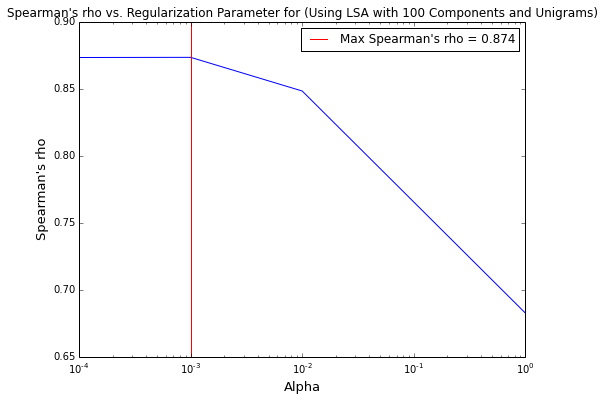

In [14]:
plot_score(alphas_3, spearman_values_3, "Spearman's rho vs. Regularization Parameter for (Using LSA with 100 Components and Unigrams)", "Alpha", "Spearman's rho", "Max Spearman's rho = {0:.3f}", "LSA(100),Unigrams")

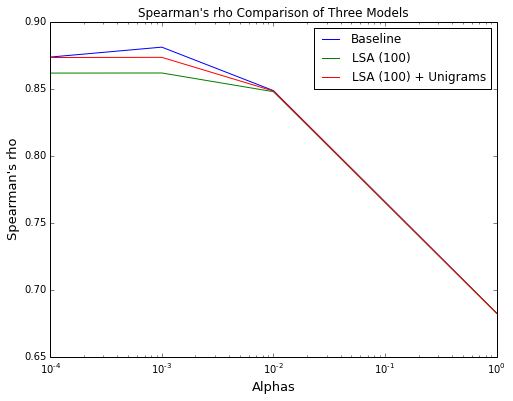

In [35]:
plt.figure(figsize=(8, 6))
plt.title("Spearman's rho Comparison of Three Models", fontsize=12)

plt.semilogx(alphas_1, spearman_values_1, label="Baseline")
plt.semilogx(alphas_2, spearman_values_2, label="LSA (100)")
plt.semilogx(alphas_3, spearman_values_3, label="LSA (100) + Unigrams")

# best_index = np.argmax(np.array(y))
# plt.axvline(x[best_index], c='r', label=vlabel.format(y[best_index]))

plt.xlabel("Alphas", fontsize=13)
plt.ylabel("Spearman's rho", fontsize=13)
plt.legend()
plt.savefig("graphs/" + "model_comparison" + ".png")
plt.show()

Testing alpha = 0.0001
Testing alpha = 0.001
Testing alpha = 0.01
Testing alpha = 1

Alphas: [0.0001, 0.001, 0.01, 1]
Spearman: [0.67800156430435976, 0.67796181917307807, 0.67632791869530884, 0.68266744887846409]


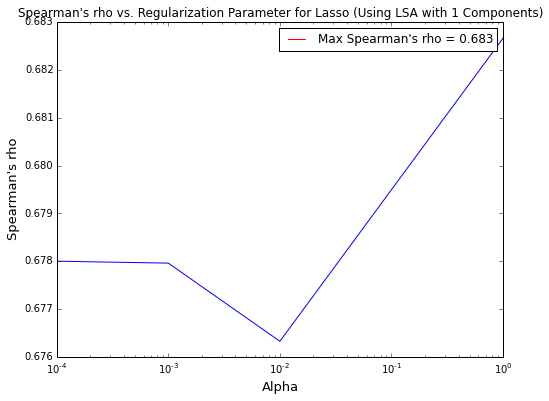

Testing alpha = 0.0001
Testing alpha = 0.001
Testing alpha = 0.01
Testing alpha = 1

Alphas: [0.0001, 0.001, 0.01, 1]
Spearman: [0.83554624068407524, 0.83671574999750709, 0.84532840377595841, 0.68252672779956458]


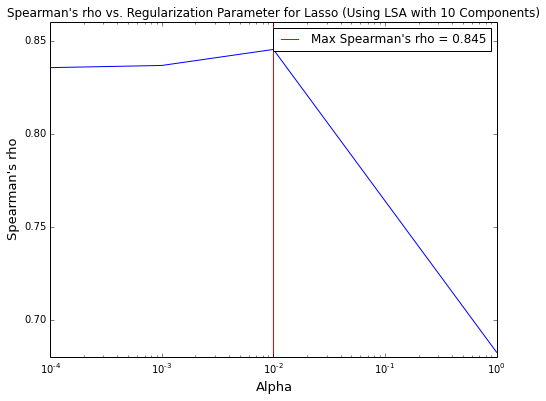

Testing alpha = 0.0001
Testing alpha = 0.001
Testing alpha = 0.01
Testing alpha = 1

Alphas: [0.0001, 0.001, 0.01, 1]
Spearman: [0.86300960772700941, 0.86289360126093073, 0.84842533254147268, 0.68275257650908694]


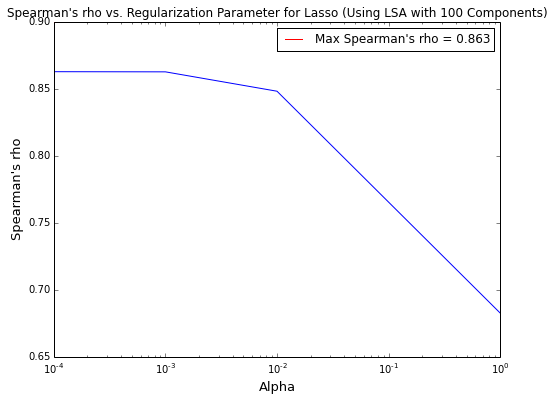

Testing alpha = 0.0001
Testing alpha = 0.001
Testing alpha = 0.01
Testing alpha = 1

Alphas: [0.0001, 0.001, 0.01, 1]
Spearman: [0.86893217523760746, 0.8697887205700412, 0.84775415242625285, 0.68277896820769246]


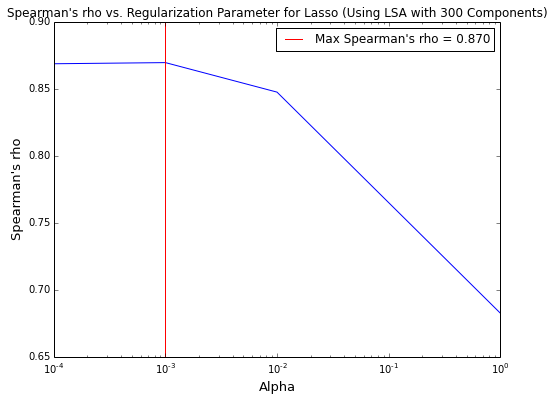

In [18]:
for n_comp in [1, 10, 100, 300]:
    # try lsa on the essay vector, and then concatenate the essay length and set
    lsa = TruncatedSVD(n_components=n_comp)
    lsa = lsa.fit_transform(sparse_essay_vector)

    X = scipy.sparse.hstack([lsa, sparse_essay_length, sparse_essay_set], format="csr")

    alphas_4, spearman_values_4 = tune_lasso(X, y)
    print "\nAlphas:", alphas_4
    print "Spearman:", spearman_values_4
    
    plot_score(alphas_4, spearman_values_4, "Spearman's rho vs. Regularization Parameter for Lasso (Using LSA with {0} Components)".format(n_comp), "Alpha", "Spearman's rho", "Max Spearman's rho = {0:.3f}", "cv_LSA({0})".format(n_comp))